Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim
Asha -
Grace -
Akhil - 
Megan - 

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

<h1> Data Preprocessing & Exploration </h1>

In [2]:
# Read in csv file
df = pd.read_csv("./data/genres.csv")

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

In [4]:
# one hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,0,0,1,0
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,0,0,1,0
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,0,0,1,0
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,0,1,0,0
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,0,0,1,0
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,0,0,1,0
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,0,0,1,0
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,0,0,1,0


In [5]:
# Separate data into features and class labels
features = df.drop('genre', axis=1)
labels = df['genre']

In [6]:
print(features.head())
label_groups = df.groupby('genre')
print(label_groups.size())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  \
0          0.013400    0.0556   0.3890  156.985       124539   
1          0.000000    0.1180   0.1240  115.080       224427   
2          0.000004    0.3720   0.0391  218.050        98821   
3          0.000000    0.1140   0.1750  186.948       123661   
4          0.000000    0.1660   0.5910  147.988       123298   

   time_signature_1  time_signature_3  time_signature_4  time_signature_5  
0                 0                 0                 1                 0  
1           

In [7]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

In [13]:
len(features)

42305

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

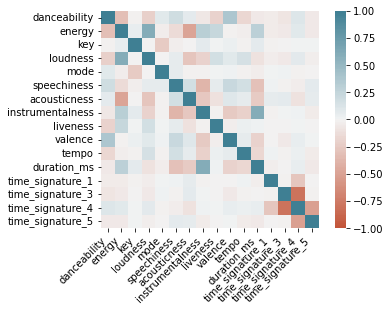

In [8]:
import seaborn as sns

# correlation between features

ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [9]:
# Perform Anomaly Detection.
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

y_pred_list = []

envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# apply IsolationForest AD
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# apply LocalOutlierFactor AD
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1,  1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

In [10]:
# Drop anomalous points.
from collections import Counter

features_no_anomalies = features.copy()
labels_no_anomalies = labels.copy()
anomaly_indices = set()
for arr in y_pred_list:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices = list(anomaly_indices)
anomaly_indices.sort()
features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
label_groups = labels_no_anomalies.groupby('genre')
print(label_groups.size())
print("\nSize of new dataset: %i" % len(features_no_anomalies))
#TODO bar graph

Counter({1: 38074, -1: 4231})
Counter({1: 37977, -1: 4328})
Counter({1: 40473, -1: 1832})
genre
Dark Trap          3103
Emo                1232
Hiphop             2019
Pop                 353
Rap                1313
RnB                1374
Trap Metal         1424
Underground Rap    4227
dnb                2718
hardstyle          2659
psytrance          2697
techhouse          2748
techno             2477
trance             2779
trap               2748
dtype: int64

Size of new dataset: 33871


In [11]:
# Downsample data to mitigate for class imbalance.
import math
import random

min_size = math.inf
for genre in label_groups.groups.keys():
    genre_group = label_groups.get_group(genre)
    if len(genre_group) < min_size:
        min_size = len(genre_group)
num_samples = min_size

# Sample same number of points from each genre to balance classes.
samp_features = []
samp_genres = []
samp_records = []
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies
genres = df_no_anomalies.groupby('genre')
for genre in genres.groups.keys():
    genre_group = genres.get_group(genre)
    genre_group_copy = genre_group.copy()
    genre_group_copy = genre_group_copy.reset_index()
    for i in range(num_samples):
        index = random.randint(0, len(genre_group_copy) - 1)
        samp_records.append(genre_group_copy.iloc[index, :])

samp_features = pd.DataFrame(samp_records).set_index('index')
samp_genres = samp_features['genre']
samp_features = samp_features.drop('genre', axis=1)
print(samp_features)
print(samp_genres)

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
index                                                                         
2641          0.593   0.737    9    -8.922     0       0.0464       0.00370   
2544          0.566   0.559    7    -9.978     0       0.3110       0.03370   
538           0.738   0.850    8    -7.181     1       0.0575       0.11500   
833           0.772   0.902    8    -6.464     1       0.1060       0.18400   
2017          0.626   0.367    8   -11.263     1       0.0343       0.00349   
...             ...     ...  ...       ...   ...          ...           ...   
27909         0.764   0.790    1    -1.844     1       0.4030       0.07660   
26200         0.662   0.965   11    -2.347     0       0.1550       0.00161   
28194         0.900   0.837    8    -5.318     0       0.3510       0.01450   
27864         0.377   0.967   10    -1.679     1       0.4360       0.00190   
28167         0.520   0.941   10    -1.952     0    

<h1> Model Building </h1>

### Neural Networks

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sn

In [16]:
# try with anomalies - 66%
# try without anomalies - 68%
# try with downsampled - 59%

### With Anomalies

<p>Using the entire dataset with 42305 records, the MLPClassifier predicted the correct genre with 66% accuracy.</p> 

In [17]:
scaler = StandardScaler()
mlp_orig = MLPClassifier(random_state=1, early_stopping=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

mlp_orig_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_orig)])
mlp_orig_grid = GridSearchCV(mlp_orig_pipe, mlp_param, n_jobs=-1, cv=5)
y_pred = cross_val_predict(mlp_orig_grid, features, labels, cv=5)

In [20]:
print('Results on the entire dataset:')
print(classification_report(labels, y_pred))

Results on the entire dataset:
                 precision    recall  f1-score   support

      Dark Trap       0.53      0.39      0.45      4578
            Emo       0.62      0.61      0.61      1680
         Hiphop       0.44      0.38      0.41      3028
            Pop       0.27      0.08      0.12       461
            Rap       0.61      0.30      0.40      1848
            RnB       0.36      0.35      0.36      2099
     Trap Metal       0.48      0.28      0.35      1956
Underground Rap       0.43      0.66      0.52      5875
            dnb       0.93      0.96      0.94      2966
      hardstyle       0.80      0.90      0.85      2936
      psytrance       0.91      0.90      0.90      2961
      techhouse       0.85      0.87      0.86      2975
         techno       0.84      0.85      0.85      2956
         trance       0.77      0.83      0.80      2999
           trap       0.80      0.79      0.79      2987

       accuracy                           0.66     4230

<AxesSubplot:>

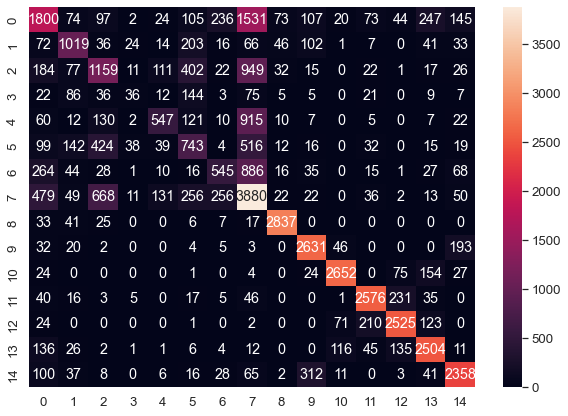

In [21]:
print('Confusion matrix for the original dataset:')
cm=metrics.confusion_matrix(labels,y_pred)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm, annot=True, fmt='g')
plt.show()

### Without Anomalies
<p> Using the dataset of size 33712 with anomalies removed (according to the anomaly detection process from earlier), the model's accuracy increased slightly to 68%. </p>

In [14]:
scaler = StandardScaler()
mlp = MLPClassifier(random_state=1, early_stopping=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

mlp_pipe = Pipeline([('scaler', scaler), ('mlp', mlp)])
mlp_grid = GridSearchCV(mlp_pipe, mlp_param, n_jobs=-1, cv=5)
y_pred = cross_val_predict(mlp_grid, features_no_anomalies, labels_no_anomalies, cv=5)

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was p

In [15]:
print('Results on the dataset without anomalies:')
print(classification_report(labels_no_anomalies, y_pred))

Results on the entire dataset:
                 precision    recall  f1-score   support

      Dark Trap       0.48      0.34      0.40      3136
            Emo       0.67      0.64      0.66      1240
         Hiphop       0.46      0.37      0.41      1966
            Pop       0.34      0.06      0.10       349
            Rap       0.54      0.24      0.33      1286
            RnB       0.37      0.34      0.36      1373
     Trap Metal       0.48      0.27      0.35      1415
Underground Rap       0.43      0.67      0.52      4158
            dnb       0.92      0.96      0.94      2766
      hardstyle       0.80      0.89      0.85      2664
      psytrance       0.90      0.91      0.90      2658
      techhouse       0.83      0.87      0.85      2749
         techno       0.84      0.84      0.84      2454
         trance       0.77      0.81      0.79      2782
           trap       0.79      0.80      0.79      2716

       accuracy                           0.68     3371

<AxesSubplot:>

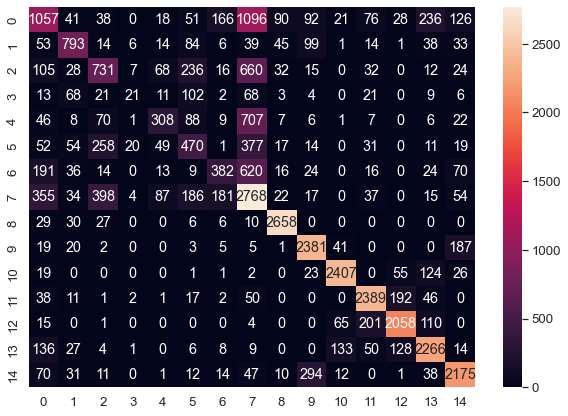

In [17]:
cm=metrics.confusion_matrix(labels_no_anomalies,y_pred)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm, annot=True, fmt='g')

### Downsampled
<p>Using the dataset with anomalies removed (according to the anomaly detection process from earlier), the model's accuracy decreased slightly to 59%.</p>

In [15]:
scaler = StandardScaler()
mlp = MLPClassifier(random_state=1, early_stopping=True, max_iter=100)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

mlp_pipe = Pipeline([('scaler', scaler), ('mlp', mlp)])
mlp_grid = GridSearchCV(mlp_pipe, mlp_param, n_jobs=-1, cv=5)
y_pred = cross_val_predict(mlp_grid, samp_features, samp_genres, cv=5)

In [16]:
print('Results on the downsampled dataset:')
print(classification_report(samp_genres, y_pred))

Results on the entire dataset:
                 precision    recall  f1-score   support

      Dark Trap       0.41      0.28      0.33       353
            Emo       0.58      0.58      0.58       353
         Hiphop       0.45      0.35      0.39       353
            Pop       0.47      0.49      0.48       353
            Rap       0.42      0.46      0.44       353
            RnB       0.35      0.33      0.34       353
     Trap Metal       0.49      0.48      0.49       353
Underground Rap       0.34      0.40      0.37       353
            dnb       0.80      0.90      0.85       353
      hardstyle       0.66      0.68      0.67       353
      psytrance       0.86      0.87      0.86       353
      techhouse       0.72      0.75      0.73       353
         techno       0.79      0.82      0.81       353
         trance       0.69      0.73      0.71       353
           trap       0.73      0.71      0.72       353

       accuracy                           0.59      529

<AxesSubplot:>

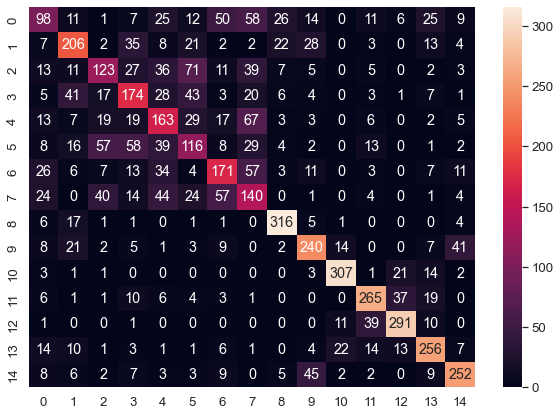

In [18]:
cm=metrics.confusion_matrix(samp_genres,y_pred)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm, annot=True, fmt='g')